<a href="https://colab.research.google.com/github/tarini3301/GGirlH25/blob/main/Pharmacist'sAssistant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
mamun1113_doctors_handwritten_prescription_bd_dataset_path = kagglehub.dataset_download('mamun1113/doctors-handwritten-prescription-bd-dataset')

print('Data source import complete.')


# Imports

In [ ]:
import pandas as pd
import numpy as np
import cv2
import os
import copy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import efficientnet_v2_s
from torchvision.models import EfficientNet_V2_S_Weights
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [ ]:
#setting seeds for reproducilibity

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

# Configuration

In [ ]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

device="cuda" if torch.cuda.is_available() else "cpu"
batch_size=8

# Exploratory Data Analysis

In [ ]:
train_dir="/kaggle/input/doctors-handwritten-prescription-bd-dataset/Doctor’s Handwritten Prescription BD dataset/Training/training_words"
val_dir="/kaggle/input/doctors-handwritten-prescription-bd-dataset/Doctor’s Handwritten Prescription BD dataset/Validation/validation_words"
test_dir="/kaggle/input/doctors-handwritten-prescription-bd-dataset/Doctor’s Handwritten Prescription BD dataset/Testing/testing_words"
train_label_filepth="/kaggle/input/doctors-handwritten-prescription-bd-dataset/Doctor’s Handwritten Prescription BD dataset/Training/training_labels.csv"
val_label_filepth="/kaggle/input/doctors-handwritten-prescription-bd-dataset/Doctor’s Handwritten Prescription BD dataset/Validation/validation_labels.csv"
test_label_filepth="/kaggle/input/doctors-handwritten-prescription-bd-dataset/Doctor’s Handwritten Prescription BD dataset/Testing/testing_labels.csv"

In [ ]:
df=pd.read_csv(train_label_filepth)
df.columns

Index(['IMAGE', 'MEDICINE_NAME', 'GENERIC_NAME'], dtype='object')

In [ ]:
medicines=['Aceta', 'Ace', 'Alatrol', 'Amodis', 'Atrizin', 'Axodin','Azithrocin', 'Azyth',
           'Az', 'Bacaid', 'Backtone', 'Baclofen','Baclon', 'Bacmax', 'Beklo', 'Bicozin',
           'Canazole', 'Candinil','Cetisoft', 'Conaz', 'Dancel', 'Denixil', 'Diflu', 'Dinafex',
           'Disopan', 'Esonix', 'Esoral', 'Etizin', 'Exium', 'Fenadin','Fexofast', 'Fexo',
           'Filmet', 'Fixal', 'Flamyd', 'Flexibac','Flexilax', 'Flugal', 'Ketocon', 'Ketoral',
           'Ketotab', 'Ketozol','Leptic', 'Lucan-R', 'Lumona', 'M-Kast', 'Maxima', 'Maxpro',
           'Metro', 'Metsina', 'Monas', 'Montair', 'Montene', 'Montex','Napa Extend', 'Napa',
           'Nexcap', 'Nexum', 'Nidazyl', 'Nizoder','Odmon', 'Omastin', 'Opton', 'Progut', 'Provair',
           'Renova','Rhinil', 'Ritch', 'Rivotril', 'Romycin', 'Rozith', 'Sergel','Tamen', 'Telfast',
           'Tridosil', 'Trilock', 'Vifas', 'Zithrin']

cls_to_label={k:v for k,v in zip(medicines,range(len(medicines)))}
label_to_cls={v:k for k,v in zip(medicines,range(len(medicines)))}

In [ ]:
name=[]
height=[]
width=[]
for img_name in os.listdir(train_dir):
    img_path=os.path.join(train_dir,img_name)
    img=cv2.imread(img_path)

    name.append(img_name)
    height.append(img.shape[0])
    width.append(img.shape[1])

In [ ]:
df_inter=pd.DataFrame({"name":name,
                       "height":height,
                       "width":width})

df_inter.head()

,name,height,width
0,2664.png,73,185
1,2539.png,38,78
2,1231.png,42,129
3,1017.png,60,180
4,2437.png,52,162


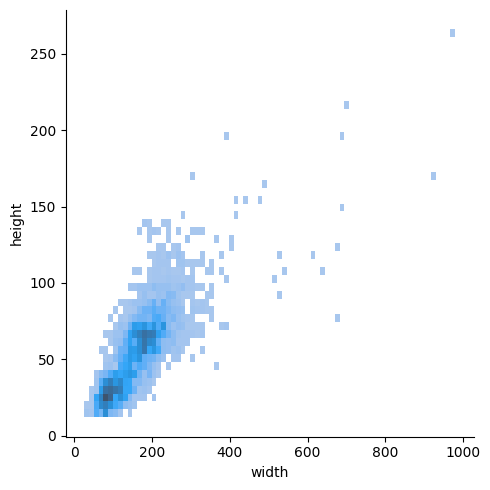

In [ ]:
sns.displot(data=df_inter,x="width",y="height");

In [ ]:
len(df_inter[(df_inter["height"]<75)&(df_inter["width"]<200)])

2169

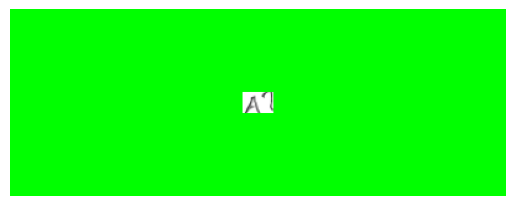

In [ ]:
"""
padding small images to the dimension (75,200) in order to preserve information
while resizing to (224,224)
"""

img_pth=os.path.join(train_dir,"339.png")
img=cv2.imread(img_pth)
img_pad=cv2.copyMakeBorder(img,top=75-img.shape[0]//2,bottom=75-img.shape[0]//2,
                           left=200-img.shape[1]//2, right=200-img.shape[1]//2,
                           borderType=cv2.BORDER_CONSTANT,value=[0,255,0])
plt.imshow(img_pad);
plt.axis("off");

# Custom Dataset Class

In [ ]:
transform=transforms.Compose([transforms.ToTensor(),
                              transforms.Resize(size=(256,256)),
                              transforms.Normalize(mean=mean,std=std)])

In [ ]:
class Prescription(Dataset):
    def __init__(self,data_dir,label_pth,transform=None):
        super().__init__()
        self.data_dir=data_dir
        self.label_pth=label_pth
        self.transform=transform

        self.img_list=sorted(list(os.listdir(data_dir)))
        self.label_df=pd.read_csv(self.label_pth)

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self,idx):
        img_name=self.img_list[idx]
        img_pth=os.path.join(self.data_dir,img_name)
        img=cv2.imread(img_pth)
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

        if img.shape[0]<75:
            img=cv2.copyMakeBorder(img,top=75-img.shape[0]//2,
                                   bottom=75-img.shape[0]//2,
                                   left=0, right=0,
                                   borderType=cv2.BORDER_CONSTANT,
                                   value=[0,255,0])

        if img.shape[1]<200:
            img=cv2.copyMakeBorder(img,top=0,bottom=0,
                                   left=200-img.shape[1]//2,
                                   right=200-img.shape[1]//2,
                                   borderType=cv2.BORDER_CONSTANT,
                                   value=[0,255,0])

        medicine_cls=self.label_df.loc[self.label_df["IMAGE"]==img_name,
                                       "MEDICINE_NAME"].values[0]
        medicine_label=cls_to_label[str(medicine_cls)]


        label=torch.tensor(medicine_label,dtype=torch.int64)

        if self.transform is not None:
            img=self.transform(img)

        return img,label


# Dataset

In [ ]:
train_ds=Prescription(train_dir,train_label_filepth,transform)
val_ds=Prescription(val_dir,val_label_filepth,transform)
test_ds=Prescription(test_dir,test_label_filepth,transform)

train_dl=DataLoader(train_ds,batch_size=batch_size,shuffle=True,num_workers=os.cpu_count(),
                    pin_memory=True if torch.cuda.is_available() else False)
val_dl=DataLoader(val_ds,batch_size=batch_size,shuffle=False,num_workers=os.cpu_count(),
                    pin_memory=True if torch.cuda.is_available() else False)
test_dl=DataLoader(test_ds,batch_size=batch_size,shuffle=False,num_workers=os.cpu_count(),
                    pin_memory=True if torch.cuda.is_available() else False)

# Data Visualization

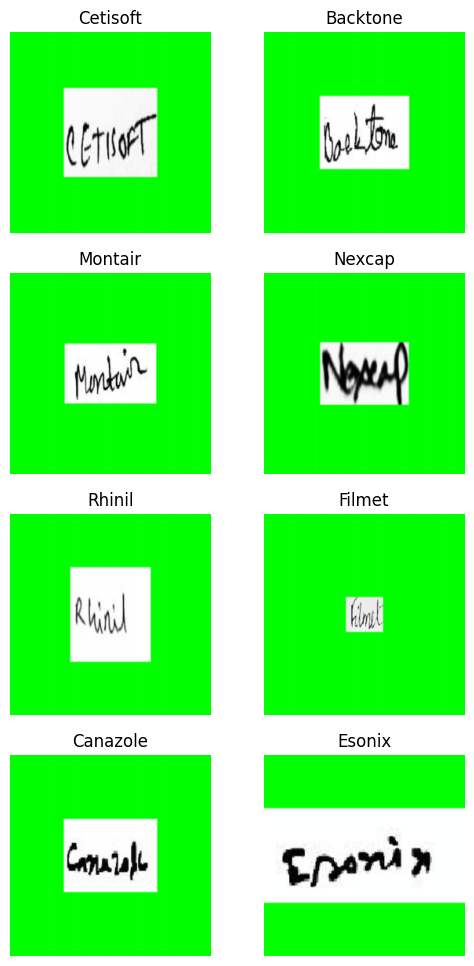

In [ ]:
fig,axes=plt.subplots(4,2,figsize=(6,12))
ax=axes.flatten()
imgs,labels=next(iter(train_dl))

for i,img in enumerate(imgs):
    imgp=np.transpose(img.numpy().copy(),(1,2,0))*std+mean
    ax[i].imshow(imgp)
    ax[i].set_title(label_to_cls[labels[i].item()])
    ax[i].axis("off")

# Training

In [ ]:
class EarlyStopping():
    def __init__(self,min_delta,patience):
        self.min_delta=min_delta
        self.patience=patience
        self.counter=0
        self.best_validation_loss=float('inf')

    def __call__(self,validation_loss):
        if (validation_loss+self.min_delta)<self.best_validation_loss:
            self.best_validation_loss=validation_loss
            self.counter=0
        else:
            self.counter+=1
            if self.counter==self.patience:
                return True

        return False


In [ ]:
def training(model,epochs,train_dl,val_dl,optimizer,loss_fn,weights_path):
    best_val_acc=0.0
    patience=10
    best_weights=copy.deepcopy(model.state_dict())
    loss_dict={"train_loss":[],"train_acc":[],"val_loss":[],"val_acc":[]}
    early_stopper=EarlyStopping(min_delta=0.05,patience=10)

    for epoch in range(epochs):

        train_loss=0.0
        train_acc=0.0
        train_len=len(train_dl.dataset)
        val_loss=0.0
        val_acc=0.0
        val_len=len(val_dl.dataset)

        model.train()
        for imgs,labels in train_dl:
            imgs,labels=imgs.to(device),labels.to(device)
            output=model(imgs)
            loss=loss_fn(output,labels)

            train_loss+=loss.item()
            pred_labels=output.argmax(dim=1)
            train_acc+=(labels==pred_labels).sum().item()

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        model.eval()
        with torch.no_grad():
            for imgs,labels in val_dl:
                imgs,labels=imgs.to(device),labels.to(device)
                output=model(imgs)
                loss=loss_fn(output,labels)

                val_loss+=loss.item()
                pred_labels=output.argmax(dim=1)
                val_acc+=(labels==pred_labels).sum().item()

        if val_acc>best_val_acc:
            best_val_acc=val_acc
            best_weights=copy.deepcopy(model.state_dict())
            print("Updating Best Model weights")

        loss_dict["train_loss"].append(train_loss/train_len)
        loss_dict["train_acc"].append(train_acc/train_len)
        loss_dict["val_loss"].append(val_loss/val_len)
        loss_dict["val_acc"].append(val_acc/val_len)

        print(f"{epoch+1}/{epochs}: Training\nloss: {train_loss/train_len} accuracy: {train_acc/train_len}")
        print(f"{epoch+1}/{epochs}: Evaluating\nloss: {val_loss/val_len} accuracy: {val_acc/val_len}")
        print("*"*50,"\n")

        if early_stopper(val_loss/val_len):
            break

    torch.save(best_weights,weights_path)
    return loss_dict

# Model

In [ ]:
def get_model(weights=None):
    model=efficientnet_v2_s(weights=weights)
    in_features=model.classifier[1].in_features
    model.classifier[1]=nn.Linear(in_features=in_features,out_features=len(medicines))
    model.to(device)

    return model

# Model Fine Tuning

In [ ]:
weights=EfficientNet_V2_S_Weights.DEFAULT
model=get_model(weights)

In [ ]:
froze_layers=["features.0","features.1","features.2","features.3","features.4"]

for names,parameters in model.named_parameters():
    if names[:10] in froze_layers:
        parameters.requires_grad=False
    else :
        parameters.requires_grad=True

parameters=[params for params in model.parameters() if params.requires_grad==True]

In [ ]:
optimizer=optim.Adam(parameters,lr=3e-5,weight_decay=3e-4)
loss_fn=nn.CrossEntropyLoss(reduction="sum")
finetuning_weights_path="/kaggle/working/finetuning_model.pth"

In [ ]:
loss_dict=training(model,70,train_dl,val_dl,optimizer,loss_fn,
                   finetuning_weights_path)

Updating Best Model weights
1/70: Training
loss: 4.27913447465652 accuracy: 0.032692307692307694
1/70: Evaluating
loss: 4.066384573471852 accuracy: 0.1282051282051282
************************************************** 

Updating Best Model weights
2/70: Training
loss: 3.9248621720534103 accuracy: 0.12051282051282051
2/70: Evaluating
loss: 3.5634662872705705 accuracy: 0.258974358974359
************************************************** 

Updating Best Model weights
3/70: Training
loss: 3.4768468202688756 accuracy: 0.21955128205128205
3/70: Evaluating
loss: 2.971180528249496 accuracy: 0.3423076923076923
************************************************** 

Updating Best Model weights
4/70: Training
loss: 2.9535183313565376 accuracy: 0.36185897435897435
4/70: Evaluating
loss: 2.4712044783127616 accuracy: 0.45256410256410257
************************************************** 

Updating Best Model weights
5/70: Training
loss: 2.4276481539775165 accuracy: 0.49775641025641026
5/70: Evaluating


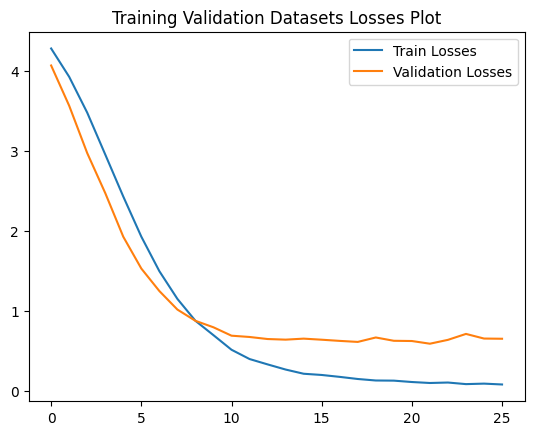

In [ ]:
x=range(len(loss_dict['train_loss']))
sns.lineplot(x=x,y=loss_dict['train_loss'],label="Train Losses");
sns.lineplot(x=x,y=loss_dict['val_loss'],label="Validation Losses");
plt.title("Training Validation Datasets Losses Plot");
plt.legend();

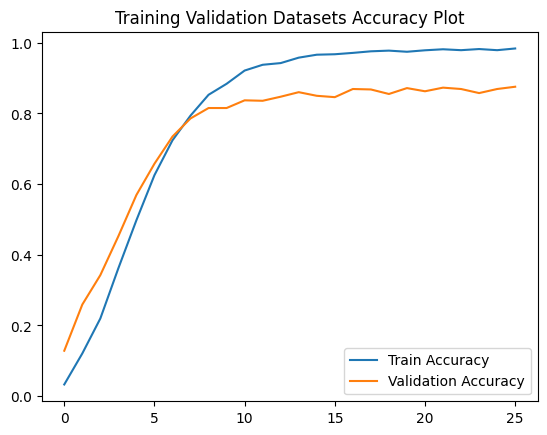

In [ ]:
sns.lineplot(x=x,y=loss_dict['train_acc'],label="Train Accuracy");
sns.lineplot(x=x,y=loss_dict['val_acc'],label="Validation Accuracy");
plt.title("Training Validation Datasets Accuracy Plot");
plt.legend();

# Inference

In [ ]:
model=get_model()
model.load_state_dict(torch.load("/kaggle/working/finetuning_model.pth"))

<All keys matched successfully>

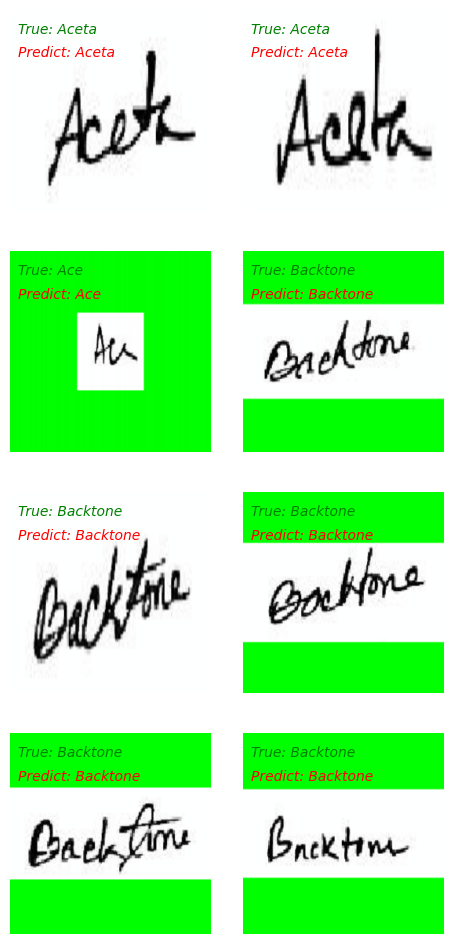

In [ ]:
fig,axes=plt.subplots(4,2,figsize=(6,12))
plt.subplots_adjust(wspace=0)
ax=axes.flatten()

imgs,labels=next(iter(test_dl))
model.eval()
with torch.no_grad():
    imgs=imgs.to(device)
    output=model(imgs)

for i in range(imgs.shape[0]):
    pred_label=output[i].argmax(0)
    ax[i].imshow(imgs[i].permute(1,2,0).cpu().numpy()*std+mean)
    ax[i].text(10,30,"True: "+ label_to_cls[labels[i].item()],style ='italic',
               fontsize = 10, color ="green")
    ax[i].text(10,60,"Predict: "+ label_to_cls[labels[i].item()],style ='italic',
                fontsize = 10, color ="red")
    ax[i].axis("off")

# Evaluation

In [ ]:
y_true=[]
y_pred=[]
model.eval()
with torch.no_grad():
    for j,(imgs,labels) in enumerate(test_dl):
        imgs,labels=imgs.to(device),labels.to(device)
        output=model(imgs)
        pred_labels=output.argmax(dim=1)
        y_true.extend(labels.tolist())
        y_pred.extend(pred_labels.tolist())

In [ ]:
accuracy=(((np.array(y_true)==np.array(y_pred)).sum())/len(y_true))
print(f"Accuracy of model on test dataset is {accuracy}")

Accuracy of model on test dataset is 0.6974358974358974


In [ ]:
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       0.89      0.80      0.84        10
           2       0.64      0.70      0.67        10
           3       0.89      0.80      0.84        10
           4       0.50      0.70      0.58        10
           5       0.40      0.80      0.53        10
           6       0.43      1.00      0.61        10
           7       0.53      1.00      0.69        10
           8       0.83      1.00      0.91        10
           9       0.77      1.00      0.87        10
          10       0.82      0.90      0.86        10
          11       0.82      0.90      0.86        10
          12       1.00      0.50      0.67        10
          13       1.00      1.00      1.00        10
          14       0.40      0.20      0.27        10
          15       1.00      0.70      0.82        10
          16       0.62      0.50      0.56        10
          17       0.73    